In [10]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#Deep Learning
import tensorflow as tf
import keras
from keras.utils.vis_utils import plot_model 
from keras import backend as K 
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.metrics import AUC
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pydot
from dask import bag,  diagnostics
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline

## Path Configuration

In [189]:
train_dir = '/opt/ml/x-ray project/X-ray-project/images/train'
validation_dir = '/opt/ml/x-ray project/X-ray-project/images/valid'
test_dir = '/opt/ml/x-ray project/X-ray-project/images/test'
test_1_dir = '/opt/ml/x-ray project/X-ray-project/images/test_1'

normal_dir = '/opt/ml/x-ray project/X-ray-project/images/valid/normal'
pneumonia_dir = '/opt/ml/x-ray project/X-ray-project/images/valid/pneumonida'
tuberculosis_dir = '/opt/ml/x-ray project/X-ray-project/images/valid/tuberculosis'

In [212]:
for path in os.listdir(test_1_dir):
    if 'ipynb' in path:
        os.rmdir(f'{test_1_dir}/{path}')

## Split dataset

In [209]:
### get images
normal_imgs = [file for file in os.listdir(f'{train_dir}/normal')]
pneumonia_imgs = [file for file in os.listdir(f'{train_dir}/pneumonia')]
tuberculosis_imgs = [file for file in os.listdir(f'{train_dir}/tuberculosis')]

### shuffle
random.shuffle(normal_imgs)
random.shuffle(pneumonia_imgs)
random.shuffle(tuberculosis_imgs)

### get len
normal_len = int(len(normal_imgs) * 0.2)
pneumonia_len = int(len(pneumonia_imgs) * 0.2)
tuberculosis_len = int(len(tuberculosis_imgs) * 0.2)

### make directories for validation dataset
os.mkdir(validation_dir)
os.mkdir(normal_dir)
os.mkdir(pneumonia_dir)
os.mkdir(tuberculosis_dir)

### move file to validation folders
# normal
imgs = normal_imgs[:normal_len]
for img in imgs:
    origin = os.path.join(f'{train_dir}/normal', img)
    dest = os.path.join(normal_dir, img)
    shutil.move(origin, dest)
# pneumonia
imgs = pneumonia_imgs[:pneumonia_len]
for img in imgs:
    origin = os.path.join(f'{train_dir}/pneumonia', img)
    dest = os.path.join(pneumonia_dir, img)
    shutil.move(origin, dest)
# tuberculosis
imgs = tuberculosis_imgs[:tuberculosis_len]
for img in imgs:
    origin = os.path.join(f'{train_dir}/tuberculosis', img)
    dest = os.path.join(tuberculosis_dir, img)
    shutil.move(origin, dest)

FileExistsError: [Errno 17] File exists: '/opt/ml/x-ray project/X-ray-project/images/valid'

## Image Preprocessing

In [213]:
# Build data generator function

def make_data_generator(
    train_datagen, train_dir, 
    val_datagen, val_dir, 
    test_datagen, test_dir,
    test_1_datagen, test_1_dir):
    
    datagen_lst = [train_datagen, val_datagen, test_datagen, test_1_datagen]
    directory_lst = [train_dir, val_dir, test_dir, test_1_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (150,150),
                                         batch_size = 128,
                                         color_mode = 'grayscale',
                                         class_mode = 'categorical',
                                         shuffle = shuffle,
                                         seed = 42)
        generator_lst.append(g)
    
    return generator_lst

# Load the images
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_1_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator, val_generator, test_generator, test_1_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir,
    test_1_datagen, test_1_dir)

Found 7390 images belonging to 3 classes.
Found 1847 images belonging to 3 classes.
Found 1596 images belonging to 3 classes.
Found 143 images belonging to 3 classes.


## Model

In [223]:
 # Design the model
    
def build_model_1():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(150, 150, 1)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    ### add layer
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))

    cnn.add(Flatten())

    cnn.add(Dense(512, activation='relu'))
    ### additional layer
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(64, activation='relu'))
    ### ends here
    cnn.add(Dense(3, activation='softmax'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
    return cnn

cnn = build_model_1()

# Train the model

cnn_model = cnn.fit(train_generator,
                      epochs = 30,
                      steps_per_epoch = len(train_generator),
                      validation_data = val_generator,
                      validation_steps = len(val_generator),
                      verbose = 1)

Epoch 1/30
58/58 [==============================] - 109s 2s/step - loss: 0.7602 - acc: 0.6604 - val_loss: 0.4642 - val_acc: 0.8073
Epoch 2/30
58/58 [==============================] - 106s 2s/step - loss: 0.4282 - acc: 0.8311 - val_loss: 0.3794 - val_acc: 0.8625
Epoch 3/30
58/58 [==============================] - 104s 2s/step - loss: 0.3542 - acc: 0.8576 - val_loss: 0.3546 - val_acc: 0.8630
Epoch 4/30
58/58 [==============================] - 106s 2s/step - loss: 0.3041 - acc: 0.8751 - val_loss: 0.2384 - val_acc: 0.9036
Epoch 5/30
58/58 [==============================] - 104s 2s/step - loss: 0.2625 - acc: 0.8934 - val_loss: 0.2066 - val_acc: 0.9210
Epoch 6/30
58/58 [==============================] - 107s 2s/step - loss: 0.2390 - acc: 0.9041 - val_loss: 0.2517 - val_acc: 0.9025
Epoch 7/30
58/58 [==============================] - 106s 2s/step - loss: 0.2241 - acc: 0.9137 - val_loss: 0.2447 - val_acc: 0.9063
Epoch 8/30
58/58 [==============================] - 106s 2s/step - loss: 0.2147 - a

## Train and Validation Loss Plot

In [224]:
# Define function for plotting train and validation curve
def train_validation_loss(cnn_model):
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    fig = plt.figure(figsize = (8,5))
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

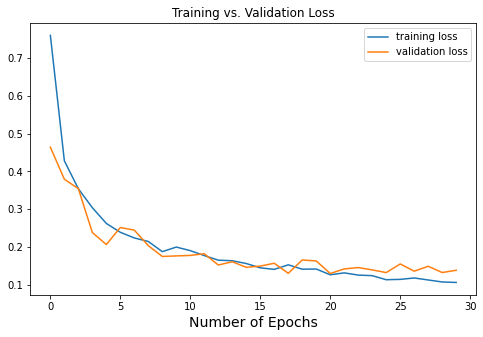

In [225]:
train_validation_loss(cnn_model)

## Train and Validation Accuracy Plot

In [226]:
# Define function for plotting train and validation curve
def train_validation_acc(cnn_model):
    train_loss = cnn_model.history['acc']
    val_loss = cnn_model.history['val_acc']
    fig = plt.figure(figsize = (8,5))
    plt.title("Training vs. Validation Acc")
    plt.plot(train_loss, label='training acc')
    plt.plot(val_loss, label='validation acc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

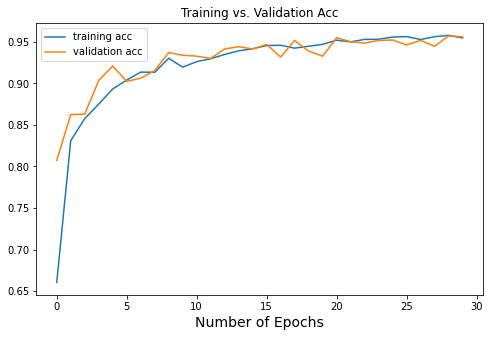

In [227]:
train_validation_acc(cnn_model)

## Summary

In [228]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
def summary(cnn):
    y_true = test_generator.classes
    Y_pred = cnn.predict(test_generator, steps = len(test_generator))
    cf_matrix = confusion_matrix(y_true, [Y_pred[i].argmax() for i in range(len(Y_pred))])
    plot_confusion_matrix(cf_matrix, hide_ticks = True, cmap = plt.cm.Blues)
    plt.title("Confusion Matrix", fontsize = 22) 
    plt.xticks(range(3), ['Normal','Pneumonia','Tuberculosis'], fontsize = 10)
    plt.yticks(range(3), ['Normal','Pneumonia','Tuberculosis'], fontsize = 10)
    
    TN, FP1, FT1, FN1, TP, FT2, FN2, FP2, TT = cf_matrix.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    #ravel, which is used to change a 2-dimensional array or a multi-dimensional array into a contiguous flattened array. 
    #The returned array has the same data type as the source array or input array.
    accuracy = (TP + TN + TT) / np.sum(cf_matrix) 
    
    precision_normal = TN / (TN + FN1 + FN2) 
    precision_pneumonia = TP / (TP + FP1 + FP2) 
    precision_tuberculosis = TT / (TT + FT1 + FT2) 
    precision_avg = (precision_normal + precision_pneumonia + precision_tuberculosis) / 3
    
    recall_normal =  TN / (TN + FP1 + FT1)
    recall_pneumonia =  TP / (TP + FN1 + FT2)
    recall_tuberculosis =  TT / (TT + FN2 + FP2)
    recall_avg = (recall_normal + recall_pneumonia + recall_tuberculosis) / 3
    
    f1 = 2*precision_avg*recall_avg / (precision_avg + recall_avg)
    
    stats_summary = f'Average: {accuracy}\n\nNormal precision: {precision_normal}\nPneumonia precision: {precision_pneumonia}\nTuberculosis precision: {precision_tuberculosis}\nAverage precision: {precision_avg}\n\nNormal Recall: {recall_normal}\nPneumonia recall: {recall_pneumonia}\nTuberculosis recall: {recall_tuberculosis}\nAverage recall: {recall_avg}\n\nF1 Score: {f1}'
    print(stats_summary)

Average: 0.9254385964912281

Normal precision: 0.9690522243713733
Pneumonia precision: 0.8798185941043084
Tuberculosis precision: 0.71900826446281
Average precision: 0.8559596943128306

Normal Recall: 0.9209558823529411
Pneumonia recall: 0.9748743718592965
Tuberculosis recall: 0.7909090909090909
Average recall: 0.8955797817071095

F1 Score: 0.8753216318306285


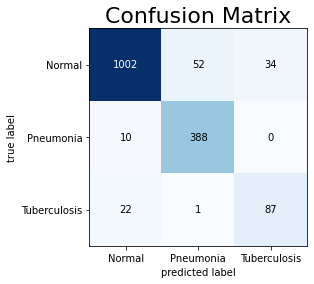

In [229]:
summary(cnn)

## Save Model

In [230]:
change = 'dense128+64+cnnLayer_epoch30'
model_dir = f'/opt/ml/x-ray project/custom_models/{change}'
os.mkdir(model_dir)
cnn.save(model_dir)

INFO:tensorflow:Assets written to: /opt/ml/x-ray project/custom_models/dense128+64+cnnLayer_epoch30/assets


## Load Model

In [ ]:
from tensorflow import keras
cnn = keras.models.load_model('/opt/ml/x-ray project/custom_models/epoch15')